## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import mysql.connector
from tqdm import tqdm


In [2]:
with open('nginx_logs - Copy.txt') as file_:
    data = file_.read()
    print(data)

74.240.191.221 - - [25/Jun/2024:00:06:22 +0000] "DELETE /index.html?product_id=585&user_id=218 HTTP/1.1" 200 1974
15.89.35.67 - - [24/Jun/2024:04:43:22 +0000] "PUT /index.html?session_id=def456&session_id=mno345&user_id=709 HTTP/1.1" 301 4349
158.20.204.46 - - [21/Jun/2024:14:54:22 +0000] "GET /contact.html?session_id=def456 HTTP/1.1" 200 4060
158.20.204.46 - - [21/Jun/2024:14:54:22 +0000] "GET /contact.html?session_id=def456 HTTP/1.1" 200 4060
238.189.173.32 - - [21/Jun/2024:21:33:22 +0000] "GET /signup?session_id=abc123&session_id=ghi789 HTTP/1.1" 500 2661
190.111.164.7 - - [26/Jun/2024:09:03:22 +0000] "GET /products.html?session_id=mno345&user_id=483 HTTP/1.1" 302 629
196.224.137.79 - - [22/Jun/2024:09:44:22 +0000] "POST /login?session_id=ghi789 HTTP/1.1" 200 2661
248.187.87.40 - - [21/Jun/2024:16:46:22 +0000] "DELETE /signup?session_id=ghi789 HTTP/1.1" 200 734
158.20.204.46 - - [24/Jun/2024:06:15:22 +0000] "DELETE /products.html?session_id=mno345&product_id=16 HTTP/1.1" 302 3432
15

In [3]:
type(data)

str

In [4]:
# WRONG!
len(data)

128093

In [5]:
df = pd.read_csv('nginx_logs - Copy.txt', 
                 sep=" ", 
                 header=None)
len(df)

1129

In [6]:
df.head()

,0,1,2,3,4,5,6,7
0,74.240.191.221,-,-,[25/Jun/2024:00:06:22,+0000],DELETE /index.html?product_id=585&user_id=218 ...,200,1974
1,15.89.35.67,-,-,[24/Jun/2024:04:43:22,+0000],PUT /index.html?session_id=def456&session_id=m...,301,4349
2,158.20.204.46,-,-,[21/Jun/2024:14:54:22,+0000],GET /contact.html?session_id=def456 HTTP/1.1,200,4060
3,158.20.204.46,-,-,[21/Jun/2024:14:54:22,+0000],GET /contact.html?session_id=def456 HTTP/1.1,200,4060
4,238.189.173.32,-,-,[21/Jun/2024:21:33:22,+0000],GET /signup?session_id=abc123&session_id=ghi78...,500,2661


## seperating requests and urls

In [7]:
def request_method_url_seprator(df, col):
    requests = []
    urls = []
    
    for da in range(len(df)):
        # seperating data into request and url
        data = df[col][da].split(' /') # here ---> ['DELETE', 'index.html?product_id=585&user_id=218 HTTP/1.1']
        # url
        urls.append('/' + data[1])
        # request
        requests.append(data[0])
    return requests , urls

In [8]:
requests, urls = request_method_url_seprator(df, 5)
urls[:9]

['/index.html?product_id=585&user_id=218 HTTP/1.1',
 '/index.html?session_id=def456&session_id=mno345&user_id=709 HTTP/1.1',
 '/contact.html?session_id=def456 HTTP/1.1',
 '/contact.html?session_id=def456 HTTP/1.1',
 '/signup?session_id=abc123&session_id=ghi789 HTTP/1.1',
 '/products.html?session_id=mno345&user_id=483 HTTP/1.1',
 '/login?session_id=ghi789 HTTP/1.1',
 '/signup?session_id=ghi789 HTTP/1.1',
 '/products.html?session_id=mno345&product_id=16 HTTP/1.1']

In [9]:
requests[:9]

['DELETE', 'PUT', 'GET', 'GET', 'GET', 'GET', 'POST', 'DELETE', 'DELETE']

In [10]:
df.head()

,0,1,2,3,4,5,6,7
0,74.240.191.221,-,-,[25/Jun/2024:00:06:22,+0000],DELETE /index.html?product_id=585&user_id=218 ...,200,1974
1,15.89.35.67,-,-,[24/Jun/2024:04:43:22,+0000],PUT /index.html?session_id=def456&session_id=m...,301,4349
2,158.20.204.46,-,-,[21/Jun/2024:14:54:22,+0000],GET /contact.html?session_id=def456 HTTP/1.1,200,4060
3,158.20.204.46,-,-,[21/Jun/2024:14:54:22,+0000],GET /contact.html?session_id=def456 HTTP/1.1,200,4060
4,238.189.173.32,-,-,[21/Jun/2024:21:33:22,+0000],GET /signup?session_id=abc123&session_id=ghi78...,500,2661


## working on timestamp

In [11]:
def timestamp_initializer(df, col1, col2):
    '''
    this function combine columns 3 and 4 which are timestamp and UTCOFFSET and returns a list
    like so:
        input date   ===> [25/Jun/2024:00:06:22	+0000] | HERE timestamp and UTC OFFSET are seperated!
        data         ===> '25/Jun/2024:00:06:22 +0000'
        output data  ===> '2024-06-24 07:04:22+00:00'  | which its data type is datetime.datetime
    output data is datetime + UTCOFFSET and then it's ready
    to be stored in the SQL database.  
    '''
    result = []
    
    for d in range(len(df)):
        date = df[col1][d][1:] + ' ' + df[col2][d][:-1]
        converted_to_datetime = datetime.strptime(date, "%d/%b/%Y:%H:%M:%S %z")
        result.append(converted_to_datetime)
    return result


In [12]:
timestamp = timestamp_initializer(df, 3, 4)
print(timestamp[1])
timestamp[1]

2024-06-24 04:43:22+00:00


datetime.datetime(2024, 6, 24, 4, 43, 22, tzinfo=datetime.timezone.utc)

## creating a new dataframe

In [13]:
def df2list(df, col):
    data_list = []
    for n in range(len(df)):
        data_list.append(df[col][n])
    return data_list

In [14]:
# status code
status_code = df2list(df, 6)
print(status_code[:9])

# response size
response_size = df2list(df, 7)
print('\n', response_size[:9],'\n')

# ip address
ip_address = df2list(df, 0)
print(ip_address[:9])

[200, 301, 200, 200, 500, 302, 200, 200, 302]

 ['1974', '4349', '4060', '4060', '2661', '629', '2661', '734', '3432'] 

['74.240.191.221', '15.89.35.67', '158.20.204.46', '158.20.204.46', '238.189.173.32', '190.111.164.7', '196.224.137.79', '248.187.87.40', '158.20.204.46']


In [15]:
c = 0
for s in response_size:
    if s == '-':
        c += 1
c

61

In [16]:
dataset = {
    'IP address': ip_address,
    'timestamp': timestamp,
    'request method': requests,
    'URL': urls,
    'status code': status_code,
    'response size (bytes)': response_size
}

new_df = pd.DataFrame(dataset)

In [17]:
new_df.head()

,IP address,timestamp,request method,URL,status code,response size (bytes)
0,74.240.191.221,2024-06-25 00:06:22+00:00,DELETE,/index.html?product_id=585&user_id=218 HTTP/1.1,200,1974
1,15.89.35.67,2024-06-24 04:43:22+00:00,PUT,/index.html?session_id=def456&session_id=mno34...,301,4349
2,158.20.204.46,2024-06-21 14:54:22+00:00,GET,/contact.html?session_id=def456 HTTP/1.1,200,4060
3,158.20.204.46,2024-06-21 14:54:22+00:00,GET,/contact.html?session_id=def456 HTTP/1.1,200,4060
4,238.189.173.32,2024-06-21 21:33:22+00:00,GET,/signup?session_id=abc123&session_id=ghi789 HT...,500,2661


## cleaning null values

In [18]:
# calculating number of null values
new_df.isnull().sum()

IP address               57
timestamp                 0
request method            0
URL                       0
status code               0
response size (bytes)     0
dtype: int64

#### from code above we can clearly see there are 57 null values in IP address column!

In [19]:
# removing null values
new_df.dropna(inplace=True)

# calculating null values again!
new_df.isnull().sum()

IP address               0
timestamp                0
request method           0
URL                      0
status code              0
response size (bytes)    0
dtype: int64

## Cleaning '-' From response size (bytes) Column

In [20]:
index_missed_values = new_df[new_df['response size (bytes)'] == '-'].index
len(index_missed_values)

58

In [21]:
new_df.drop(index_missed_values, inplace=True)

In [22]:
new_df.tail()

,IP address,timestamp,request method,URL,status code,response size (bytes)
1124,147.77.212.177,2024-06-23 20:12:22+00:00,POST,/login?product_id=15&product_id=900 HTTP/1.1,500,4049
1125,13.224.24.185,2024-06-25 22:48:22+00:00,DELETE,/services.html?product_id=6&session_id=abc123 ...,301,1500
1126,35.239.32.150,2024-06-20 08:28:22+00:00,POST,/index.html?product_id=170 HTTP/1.1,200,4292
1127,151.80.55.55,2024-06-19 20:48:22+00:00,DELETE,/index.html?user_id=834 HTTP/1.1,301,3508
1128,255.181.37.177,2024-06-24 07:04:22+00:00,GET,/products.html?product_id=267&category=home HT...,404,1500


<hr>

## DataBase

In [23]:
try:
    my_database = mysql.connector.connect(
        host = 'localhost',
        user = 'root',
        password = '1234')
    cursor = my_database.cursor()
    print('Connected to Database!')
except Exception as e:
    print(e)

Connected to Database!


In [24]:
# creating a new database
db_name = 'test'
try:
    sql = f'CREATE DATABASE {db_name}'
    cursor.execute(sql)
    print("Database created!")
    # print(f'Database {db_name} is ready to use!')
except:
    print("Database already created!")
cursor.execute('USE test;')

Database created!


In [25]:
my_database.database = db_name

In [26]:
cursor.execute("SHOW DATABASES;")
cursor.fetchall()

[('information_schema',),
 ('mysql',),
 ('performance_schema',),
 ('sakila',),
 ('sys',),
 ('test',),
 ('world',)]

In [27]:
try:
    sql = """
            CREATE TABLE IF NOT EXISTS Ngnix(
                id INT AUTO_INCREMENT,
                IP_address VARCHAR(255),
                timestamp TIMESTAMP,
                request_method VARCHAR(255),
                url VARCHAR(255),
                status_code INT NOT NULL,
                response_size INT NOT NULL,
                PRIMARY KEY (id)
            );
    """
    cursor.execute(sql)
    print('Table Ngnix created!')
except Exception as e:
    print('Table already created!')
    print(e)

Table Ngnix created!


In [28]:
cursor.execute('SHOW TABLES;')
cursor.fetchall()

[('ngnix',)]

### Inserting Data

In [29]:
new_df.columns

Index(['IP address', 'timestamp', 'request method', 'URL', 'status code',
       'response size (bytes)'],
      dtype='object')

In [30]:
for n in tqdm(range(len(new_df))):
    try:
        data = new_df.iloc[n, :]
        sql =  '''
            INSERT INTO Ngnix (IP_address, timestamp, request_method, url, status_code, response_size)
            VALUES (%s, %s, %s, %s, %s, %s);
        '''
        val = (data['IP address'], data['timestamp'], data['request method'], data['URL'], int(data['status code']), data['response size (bytes)'])
        cursor.execute(sql, val)
        my_database.commit()
        # print('data added!')
    except Exception as e:
        print()
        print(data)
        print()
        print(e)

  2%|▏         | 19/1014 [00:00<00:05, 186.40it/s]

100%|██████████| 1014/1014 [00:04<00:00, 209.53it/s]


In [31]:
# show added data
sql = '''SELECT * FROM Ngnix;'''
cursor.execute(sql)
all_data = cursor.fetchall()

print(f'length of data stored in dataframe   : {len(new_df)}')
print(f'length of data stored in SQL database: {len(all_data)}')

length of data stored in dataframe   : 1014
length of data stored in SQL database: 1014


In [32]:
all_data[1]

(2,
 '15.89.35.67',
 datetime.datetime(2024, 6, 24, 4, 43, 22),
 'PUT',
 '/index.html?session_id=def456&session_id=mno345&user_id=709 HTTP/1.1',
 301,
 4349)

In [33]:
# finding maximum length of input
def find_max(data):
    mx = 0
    for d in data:
        if len(d) > mx:
            mx = len(d)
    return mx

print(f'urls max len: {find_max(urls)}')
print(f'request methods max len: {find_max(requests)}')

urls max len: 77
request methods max len: 6


<!DOCTYPE html>
<html>
    <body>

<h1>Stored Data in MySQL | database name is test</h1>

<img src="sql_img.png" alt="Girl in a jacket" width="1610" height="690">

</body>
</html>

<hr>

## Data Visualization | Data Is Loaded From the Database

#### different types of request methods in PI and BAR graph

In [34]:
sql = "SELECT request_method FROM Ngnix;"
cursor.execute(sql)
sql_reqest_methods = cursor.fetchall()
sql_reqest_methods[:2]

[('DELETE',), ('PUT',)]

In [35]:
def sql_executer_with_condition(sql_command, condition=None):
    try:
        cursor.execute(sql_command, condition)
        result = cursor.fetchall()
        if len(result) != 0:
            return result
    except Exception as e:
        print(e)

In [36]:
# working only with non duplicated values
sql_reqest_methods = list(set(sql_reqest_methods))

In [37]:
rq_methods = []
for da in sql_reqest_methods:
    rq_methods.append(da[0])
rq_methods

['DELETE', 'POST', 'PUT', 'GET']

In [38]:
sql_delete = sql_executer_with_condition('SELECT COUNT(*) FROM Ngnix WHERE request_method = %s', ['DELETE'])
sql_post = sql_executer_with_condition('SELECT COUNT(*) FROM Ngnix WHERE request_method = %s', ['POST'])
sql_get = sql_executer_with_condition('SELECT COUNT(*) FROM Ngnix WHERE request_method = %s', ['GET'])
sql_put = sql_executer_with_condition('SELECT COUNT(*) FROM Ngnix WHERE request_method = %s', ['PUT'])
num_rq_method = [sql_delete[0][0], sql_post[0][0], sql_get[0][0], sql_put[0][0]]
num_rq_method

[268, 228, 246, 272]

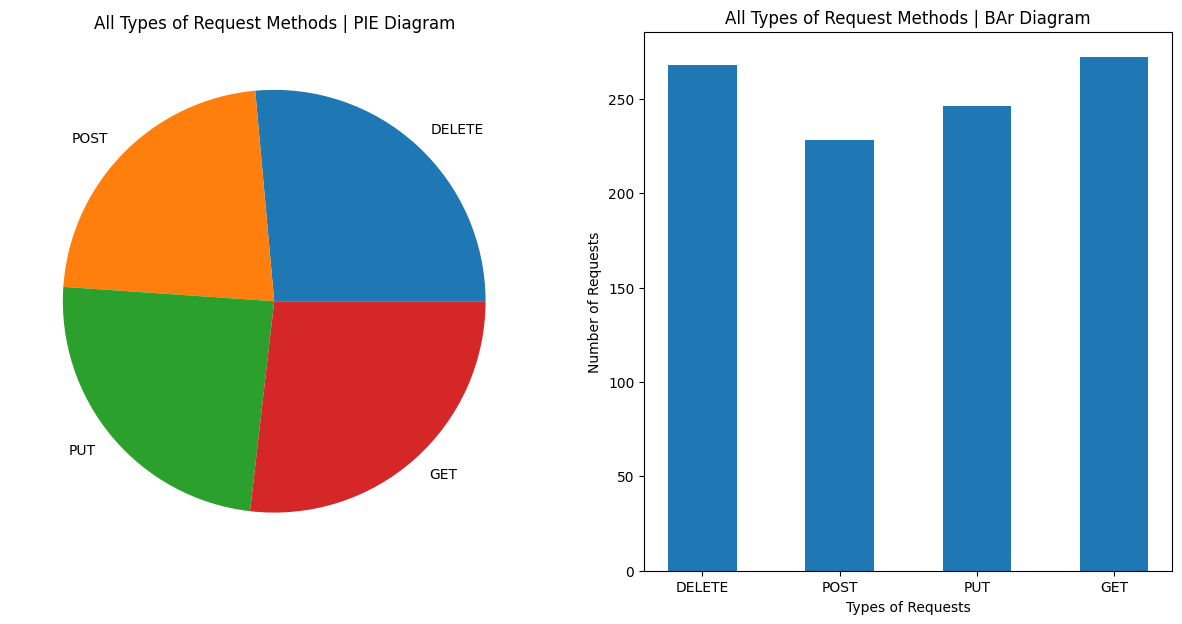

In [39]:
fig = plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.title('All Types of Request Methods | PIE Diagram')
plt.pie(num_rq_method, labels=rq_methods)

plt.subplot(1, 2, 2)
plt.bar(rq_methods, num_rq_method, width=0.5)
plt.ylabel('Number of Requests')
plt.xlabel('Types of Requests')
plt.title('All Types of Request Methods | BAr Diagram')
 
# show plot
plt.show()

#### Visualizing timestamp and response size

In [40]:
# working on timestamp
sql_timestamp = sql_executer_with_condition('SELECT timestamp FROM Ngnix;')

std_timestamp = []

for i in range(len(sql_timestamp)): 
    std_timestamp.append(sql_timestamp[i][0])

std_timestamp[:3]

[datetime.datetime(2024, 6, 25, 0, 6, 22),
 datetime.datetime(2024, 6, 24, 4, 43, 22),
 datetime.datetime(2024, 6, 21, 14, 54, 22)]

In [41]:
# working on response size
sql_response = sql_executer_with_condition('SELECT response_size FROM Ngnix;')

In [42]:
std_response = []
for j in range(len(sql_response)):
    std_response.append(sql_response[j][0])
std_response[:3]

[1974, 4349, 4060]

In [43]:
zz = []
for k in range(len(std_timestamp)):
    sss = pd.to_datetime(std_timestamp[k])
    zz.append(sss)
zz[:4]

[Timestamp('2024-06-25 00:06:22'),
 Timestamp('2024-06-24 04:43:22'),
 Timestamp('2024-06-21 14:54:22'),
 Timestamp('2024-06-21 14:54:22')]

In [44]:
len(zz), len(std_response)

(1014, 1014)

In [45]:
zz = list(set(zz))
std_response = list(set(std_response))
zz[:7]

[Timestamp('2024-06-21 21:33:22'),
 Timestamp('2024-06-23 14:28:22'),
 Timestamp('2024-06-25 03:47:22'),
 Timestamp('2024-06-26 16:59:22'),
 Timestamp('2024-06-25 02:02:22'),
 Timestamp('2024-06-24 04:25:22'),
 Timestamp('2024-06-20 12:39:22')]

In [46]:
# plt.scatter(std_response)

In [47]:
# plt.stem(zz, std_response)

In [48]:
# sql = f'DROP DATABASE {db_name}'
# cursor.execute(sql)

C:\Users\Smart\AppData\Local\Temp\ipykernel_9232\1102851531.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql_2_df = pd.read_sql_query('select * from ngnix;', my_database)


## MySQL to CSV and EXCEL Files

In [50]:
sql_2_df = pd.read_sql_query('select * from ngnix;', my_database)
sql_2_df.to_csv('sql_database.csv', index=False)
sql_2_df.to_excel('sql_database.xlsx', index=False)